# Survival analysis: a linear approach

Survival analysis is a branch of statistics that analyses the expected duration of time till one or more events will happen. Originating from biomedicine, a lot of studies have focused on time till death / recovery following medical treatment. The method can also be successfully applied to all kinds of industries, to name a few: 
- predicting customer / employee churn for marketing or HR, 
- probability of default modelling for the banking and insurance industry, 
- time till failure for utility maintenance,
- ... .

What all these business questions have in common is that they want to model a censored event, meaning: for some observations we did not observe the event taking place (maybe it will never take place). As a result, these business questions are mostly modelled using a classification approach: a time-window is selected and one classifies whether an event will take place during that time-window or not. 
However, this approach has some down-sides: 
- the criteria to select the time-window are _arbitrarily_, 
- information during this time-window cannot be used as it is part of the target, 
- a complete neglectance of the aspect _time_ till the event takes place. 

Naturally, survival analysis solves the above down-sides by explicitly optimizing an objective function that takes the censoring into account. Then why is it not very well-known? 
One answer may lie in the fact that survival modelling - the relationship between the survival curve and observation characteristics - is quite new. It was only in 1972 that David Cox provided us with a toolset to model the relationship between survival and observation characteristics. 

In this notebook, I provide a genuine introduction to survival analysis in Python. That is, I will for the moment not focus on more advanced methodologies that deal with time-dependent covariates, left truncation nor implement any of the more flexible machine (deep) learning approaches. These may be part of later, upcoming notebooks. 
As a business case, I will attempt to model customer churn at the telecom sector by making use of the publicly available IBM telecom dataset. The dataset has been extensively used as part of the Kaggle datasets and thereby was extensively studies by classification approaches (a good example is https://towardsdatascience.com/predict-customer-churn-with-r-9e62357d47b4).

While I have a lot of experience in survival analysis in R, I am quite new in the Python environment. As such, these notebooks serve to warm-up my coldwater feets as well.

Have a nice read!

## Some basic concepts

Before making our hands dirty with some code, lets first introduce some concepts. 

## Setting-up the work environment

In [31]:
import os
import csv
print(os.getcwd())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lifelines
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

C:\Users\vande70\OneDrive - Cronos\Cursussen\Survival Analysis\code


## Inspecting the data

In [32]:
#churn = csv.reader('..\data\telco-customer-churn.csv', delimiter=',')
churn = pd.read_csv('..\data\WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col='customerID')

print(churn.shape)
print(churn.info())
print(churn.isnull().sum())

(7043, 20)
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), object(17)
memory usage

To model customer churn using survival analysis, we need to have two types of information: (1) a time indicator that specifies a duration till last day of observation or any given month of observation and (2) an indicator whether churn was observed or not. In this dataset, we have a variable tenure (in months) that describes the duration till last observation and a variable churn that specifies whether the churn event takes place.   

In [33]:
print(churn['tenure'].describe())
print(pd.value_counts(churn['Churn']) / len(churn))
# we recode our outcome variable as being binary (0: no churn, 1: churn)
churn["Churn"] = np.where(churn['Churn']=='Yes', 1, 0)
print(pd.value_counts(churn['Churn']) / len(churn))

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64
No     0.73463
Yes    0.26537
Name: Churn, dtype: float64
0    0.73463
1    0.26537
Name: Churn, dtype: float64


We find the average tenure at point of last observation to be 32.3 months. This is an underestimation for the average tenure of clients given that only 26 percent of the clients witnessed churn during the time of observation.
Combining these two pieces, we can create our main descriptive statistics: (1) the survival curve and (2) the hazard curve. 

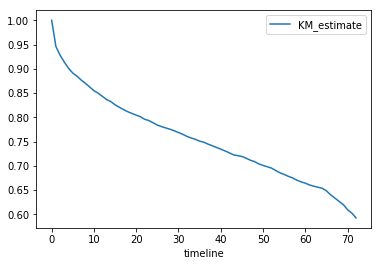

In [34]:
kmf = KaplanMeierFitter()
kmf.fit(churn['tenure'], event_observed=churn['Churn'])
kmf.survival_function_.plot()

anf